<a href="https://colab.research.google.com/github/d0ctaa/Torch/blob/main/Chest_RX_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torchmetrics

In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import torchvision.models as models
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from torchvision.models import ResNet50_Weights
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
import torchvision.transforms.functional as F
import torch.nn.functional as f
from torchmetrics.functional import auroc
from sklearn.metrics import auc, f1_score


In [ ]:
device = torch.device('cuda')

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
torch.__version__

'2.2.1+cu121'

In [ ]:
!nvidia-smi

Sat Apr 13 19:02:50 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

> Transforms for the Dataset

In [ ]:
#Defining transforms to be applied to the images

transform = v2.Compose([
    v2.Resize((224, 224)),
    v2.Grayscale(num_output_channels=3),
    v2.RandomRotation(degrees=(0, 180)),
    v2.RandomVerticalFlip(p=0.25),
    v2.RandomHorizontalFlip(p=0.25),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485], std=[0.229])
])

> Import Dataset. Training and Testing

In [ ]:
MainSet = ImageFolder(root='/content/gdrive/MyDrive/data_chest_xray/train', transform=transform) # Train Dataset containing Normal and Pneumonia X-Rays

testSet = ImageFolder(root='/content/gdrive/MyDrive/data_chest_xray/test', transform=transform) # Test Dataset containing Normal and Pneumonia X-Rays

> Create a validation Set

In [ ]:
valSize = int(len(MainSet)* 0.2) #Take 20% of the main training set for validation
trnSize = len(MainSet)-valSize # The remaining 80% goes to the final training set

#Making the split with the size created above.
trainSet, valSet = random_split(MainSet, [trnSize, valSize])

**Create data loader:**
 - Train,
 - Validate,
 - Test datasets

In [ ]:
trainLoader = DataLoader(trainSet, batch_size=32, shuffle=True)
ValidLoader = DataLoader(valSet, batch_size=32, shuffle=False )
testLoder = DataLoader (testSet, batch_size=32, shuffle=False)

 Instantiate the model & Add Regularization(Dropout)

In [ ]:
#Instantiate model
res_model_1 = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

#Modify model to add dropout
num_features = res_model_1.fc.in_features
dropout_prob = 0.5  # Example dropout probability
res_model_1.fc = nn.Sequential(
    nn.Linear(num_features, 512),  # Example additional layer
    nn.ReLU(inplace=True),
    nn.Dropout(dropout_prob),  # Dropout layer
    nn.Linear(512, len(MainSet.classes))  # Example output layer
)

> Create Loss Function and Optimizers

In [ ]:
criterion = nn.CrossEntropyLoss() #Loss Function

optimizer = optim.SGD(res_model_1.parameters(),lr=0.01) #Optimizer

> Training Loop

In [ ]:
torch.cuda.is_available()

True

#### OOLLO
* Optimizer.zero_grad()
* Output = model(data)
* Loss = criterion(output, target)
* Loss.backward()
* Optimizer.step()

In [ ]:
device = torch.device('cuda')
lossVals = []
epochVals = []

# Move model to GPU
res_model_1.to(device)


for epoch in range(50):
  res_model_1.train() #Setting the model to training mode
  for data, label in trainLoader:

    #move the code to run on gpu
    data, label = data.to(device), label.to(device)

    #Reset Gradient to zero so it doesn't accumulate
    optimizer.zero_grad()

    #Put Data trough the model
    res_output = res_model_1(data)

    #Calculate the Loss
    loss = criterion(res_output, label)

    #Back Propagation using autograd
    loss.backward()

    #Gradient Descent
    optimizer.step()

  lossVals.append(loss.item())
  epochVals.append(epoch)

  print(f"the Loss at {epoch} is: {loss.item()}")

the Loss at 0 is: 0.3814307451248169
the Loss at 1 is: 0.20651748776435852
the Loss at 2 is: 0.11914914101362228
the Loss at 3 is: 0.04209209233522415
the Loss at 4 is: 0.3102274537086487
the Loss at 5 is: 0.11081718653440475
the Loss at 6 is: 0.30483609437942505
the Loss at 7 is: 0.06920911371707916
the Loss at 8 is: 0.01619032956659794
the Loss at 9 is: 0.026751333847641945
the Loss at 10 is: 0.05396253988146782
the Loss at 11 is: 0.08593491464853287
the Loss at 12 is: 0.031097663566470146
the Loss at 13 is: 0.014696038328111172
the Loss at 14 is: 0.018371785059571266
the Loss at 15 is: 0.009674208238720894
the Loss at 16 is: 0.11525299400091171
the Loss at 17 is: 0.027542805299162865
the Loss at 18 is: 0.08838570863008499
the Loss at 19 is: 0.10220660269260406
the Loss at 20 is: 0.2235364317893982
the Loss at 21 is: 0.024093087762594223
the Loss at 22 is: 0.02610643021762371
the Loss at 23 is: 0.0022691034246236086
the Loss at 24 is: 0.05323059484362602
the Loss at 25 is: 0.01591800

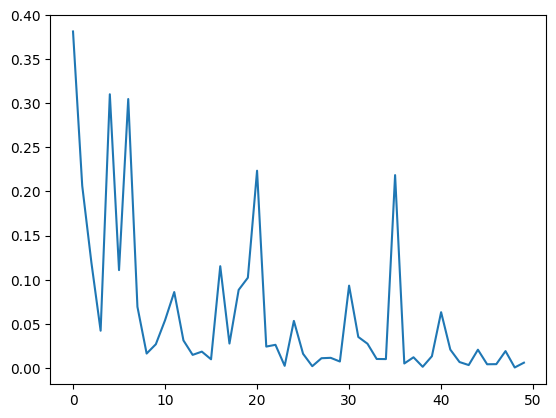

In [ ]:
fig, ax = plt.subplots()
ax.plot(epochVals, lossVals)
plt.show()

## Evaluation Loop

### Save Model to google Drive

In [ ]:
torch.save(res_model_1.state_dict(), '/content/gdrive/MyDrive/model_checkpoint.pth')

### Load Model from a saved state

In [ ]:
model_path = '/content/gdrive/MyDrive/model_checkpoint.pth'
res_model_1.load_state_dict(torch.load(model_path))

<All keys matched successfully>

### Evaluation Loop

In [ ]:
res_model_1.to(device) #Move the newly loaded model from gdrive to GPU
res_model_1.eval() #Set Model to evaluation state. This turns off AutoGrad
val_results = [] # Empty list to store Evaluation results from each loop
val_labels = [] # Storing the corresponding labels

with torch.inference_mode():
  for data, label in ValidLoader:
    data, label = data.to(device), label.to(device)

    validation_preds = res_model_1(data)
    val_results.append(validation_preds)

    val_labels.append(label)

#raw output from forward pass
logits = torch.cat(val_results, dim=0)

#Corresponding labels of data ran trough outputs
vLabels = torch.cat(val_labels, dim=0)


### Convert Logits to Probabilities

In [ ]:
#Calculate probabilities for the logits. The sigmoid activation function is use due to doing a binary classification
probabilities = f.sigmoid(logits)

In [ ]:
#Confirming the shape of our probabilities
probabilities.shape

torch.Size([1055, 2])

### Convert Probabilities to Prediction

In [ ]:
predicted_indicies = torch.argmax(probabilities, dim=1)

In [ ]:
predicted_indicies

1055

### Evaluation Metrics

In [ ]:
correct_preds = (vLabels == predicted_indicies)

In [ ]:
#Compute the Accuracy
accuracy = correct_preds.float().mean()

In [ ]:
accuracy

tensor(0.9791, device='cuda:0')

In [ ]:
#Compute the Receiver Operating Characteristic - Area Under the Curve
auc_roc = auroc(probabilities[:, 1], vLabels, task="binary")

In [ ]:
auc_roc

tensor(0.9970, device='cuda:0')

## Next: build a testing loop